In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from numpy.random import default_rng
from pytensor import tensor as pt
from scipy.integrate import odeint

In [2]:
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=(FutureWarning, UserWarning))
RANDOM_SEED = 1234
np.random.seed(RANDOM_SEED)
rng = default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89


def normalize(x):
    return (x - np.mean(x)) / np.std(x)

#### Code 16.1

In [3]:
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
# scale observed variables
d["w"] = d["weight"] / d["weight"].mean()
d["h"] = d["height"] / d["height"].mean()

#### Code 16.2

In [5]:
with pm.Model() as m16_1:
    sigma = pm.Exponential("sigma", 1)
    k = pm.Exponential("k", 0.5)
    p = pm.Beta("p", alpha=2, beta=18)
    mu = pm.Deterministic("mu", pt.log(np.pi * k * pt.pow(p, 2.0) * pt.pow(d.h.values, 3.0)))
    w = pm.Lognormal("w", mu, sigma, observed=d.w.values)
    idata_16_1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, k, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 268 seconds.


A prior predictive check is not done in the book, but it is alluded to: the author acknowledges that the priors could be improved, but the data will drive the posterior. So let's have a look at how bad these priors are.

Sampling: [k, p, sigma, w]


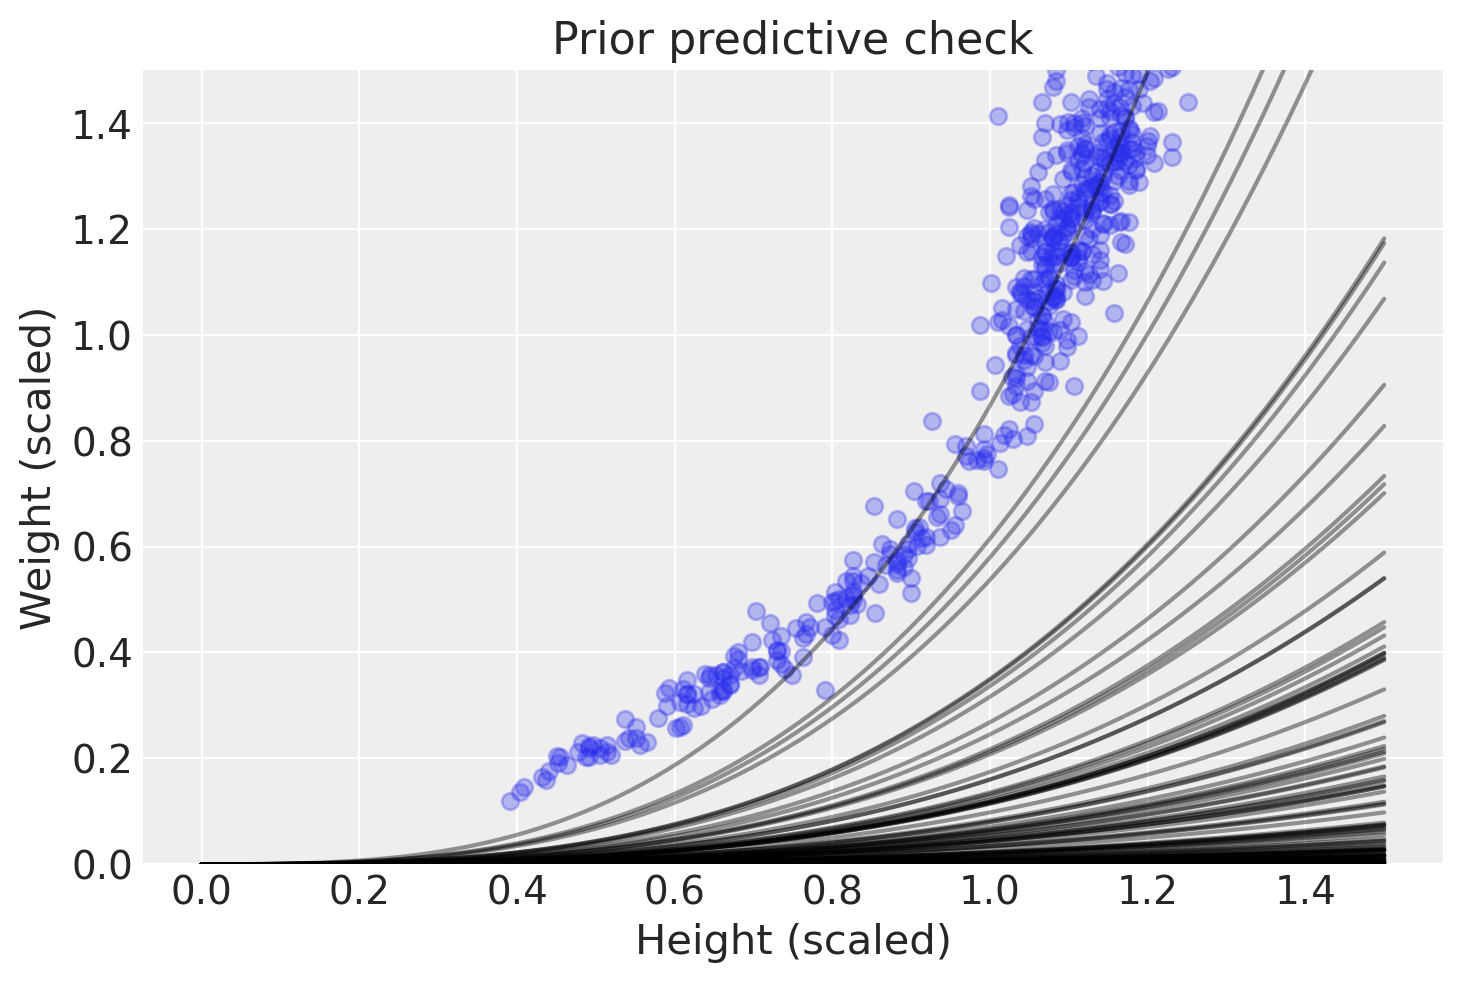

In [6]:
n_samples = 100
h_ppc = np.linspace(0, 1.5, n_samples)

with m16_1:
    prior_checks = pm.sample_prior_predictive(samples=n_samples)

k = np.array((prior_checks["prior"][["k"]]).to_array()).reshape(n_samples, 1)
p = np.array((prior_checks["prior"][["p"]]).to_array()).reshape(n_samples, 1)
w_ppc = np.dot(np.pi * k * p**2, h_ppc.reshape(1, 100) ** 3)

_, ax = plt.subplots()
for w in w_ppc:
    ax.plot(h_ppc, w, c="k", alpha=0.4)

ax.scatter(d.h, d.w, c="C0", alpha=0.3)
ax.set_ylim([0, 1.5])
ax.set_xlabel("Height (scaled)")
ax.set_ylabel("Weight (scaled)")
ax.set_title("Prior predictive check");

So clearly some refinement in the priors could be made (e.g. try $k \sim \rm{Exp}(0.25)$ and $p \sim \rm{Beta}(2, 5)$), but let's stick with the priors in the book.

In [7]:
with m16_1:
    idata_16_1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, k, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 186 seconds.


In [8]:
varnames = ["~mu"]
az.summary(idata_16_1, kind="stats", var_names=varnames)

,mean,sd,hdi_5.5%,hdi_94.5%
sigma,0.207,0.006,0.197,0.217
k,5.876,2.683,2.008,9.507
p,0.244,0.054,0.163,0.328


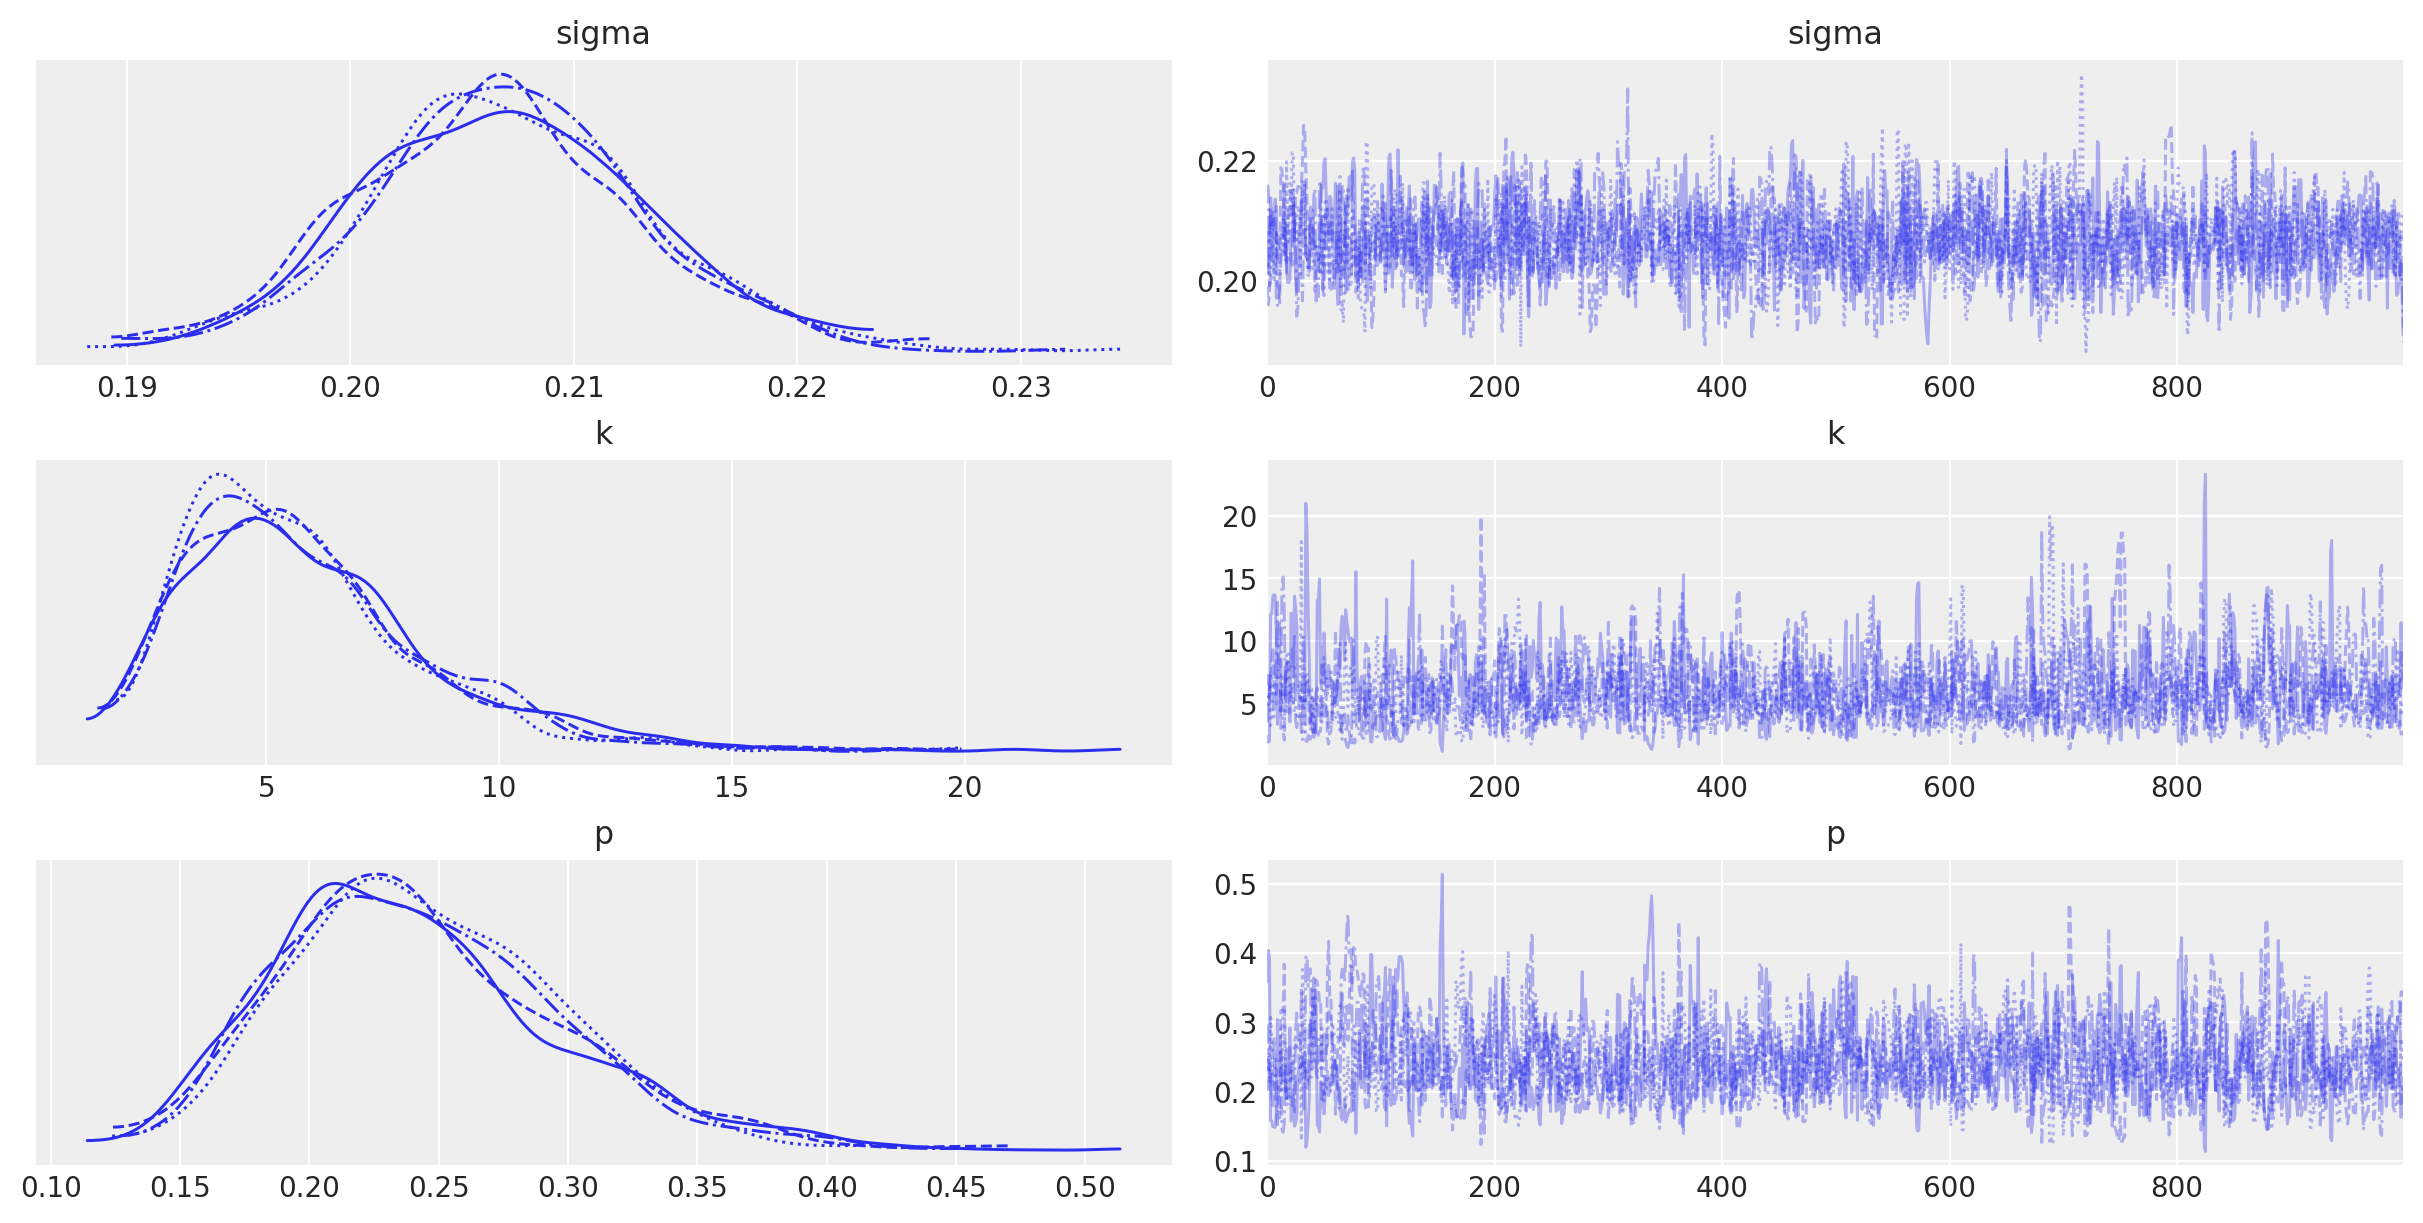

In [9]:
az.plot_trace(idata_16_1, varnames);

The divergences/warnings give us a clue that something in the model isn't working very well. The book explores this through the pairs plot of `k` and `p`

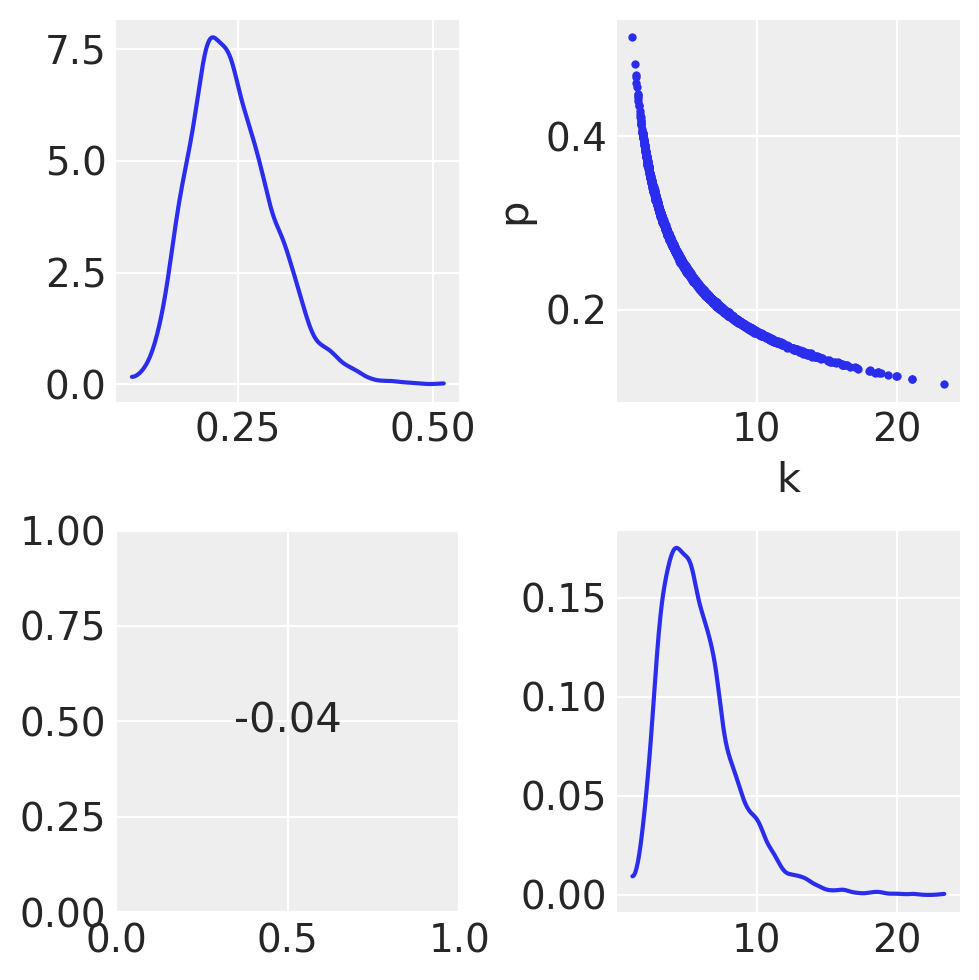

In [10]:
# Replicates Fig 16.2 (left) in the text
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(5, 5))
az.plot_kde(np.array(idata_16_1["posterior"]["p"]), ax=ax1)
az.plot_pair(idata_16_1["posterior"], var_names=["k", "p"], kind="scatter", ax=ax2)
az.plot_kde(np.array(idata_16_1["posterior"]["k"]), ax=ax4)
corr = np.corrcoef(idata_16_1["posterior"]["p"], idata_16_1["posterior"]["k"])[0, 1]
ax3.text(
    0.5,
    0.5,
    f"{corr:.2f}",
    fontsize=15,
    verticalalignment="center",
    horizontalalignment="center",
)
plt.tight_layout();

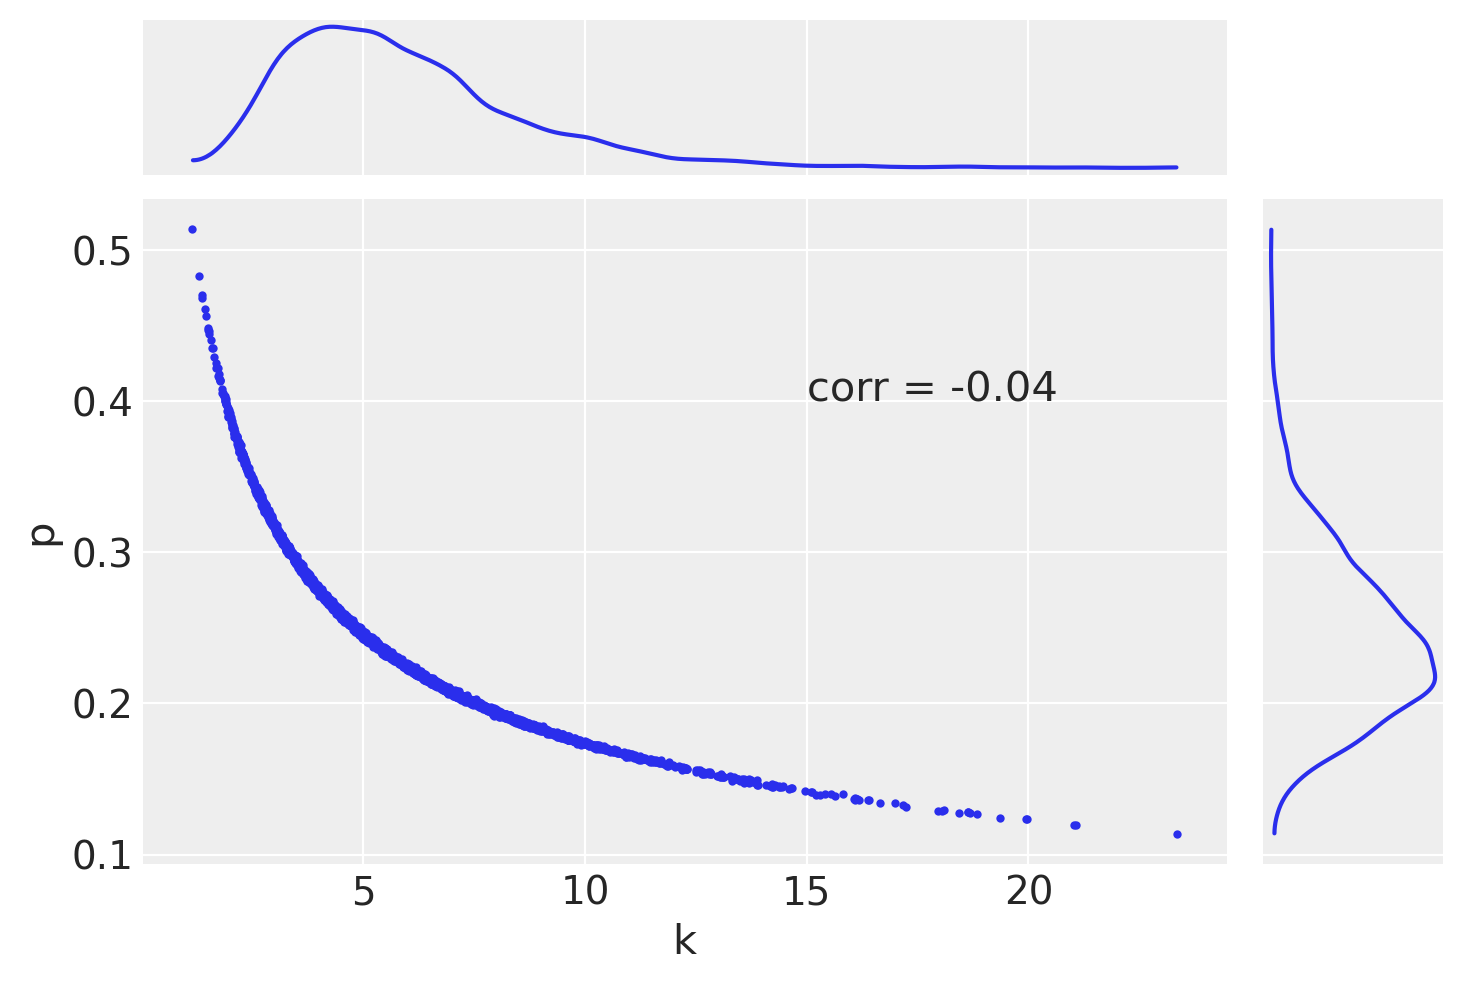

In [11]:
# A more native pymc/Arviz representation
axes = az.plot_pair(idata_16_1, var_names=["k", "p"], kind="scatter", marginals=True)
corr = np.corrcoef(idata_16_1["posterior"]["p"], idata_16_1["posterior"]["k"])[0, 1]
axes[1, 0].text(15, 0.4, f"corr = {corr:.2f}", fontsize=15);

The narrow curved ridge is caused by combinations of `p` and `k` where the product $kp^2$ is a constant.

#### Code 16.3

It is possible to draw the hpd for the entire range of `h_seq` below, by manually resampling the model from the Lognormal distribution, but here we are satisfied with the _Arviz_ hpd region which covers the range of the data.

In [12]:
with m16_1:
    w_sim = pm.sample_posterior_predictive(idata_16_1)["posterior_predictive"]["w"]
h_seq = np.linspace(0, d.h.max(), 30)
mu_mean = (
    np.array(np.pi * (idata_16_1["posterior"]["k"] * idata_16_1["posterior"]["p"] ** 2).mean())
    * h_seq**3
)

Sampling: [w]


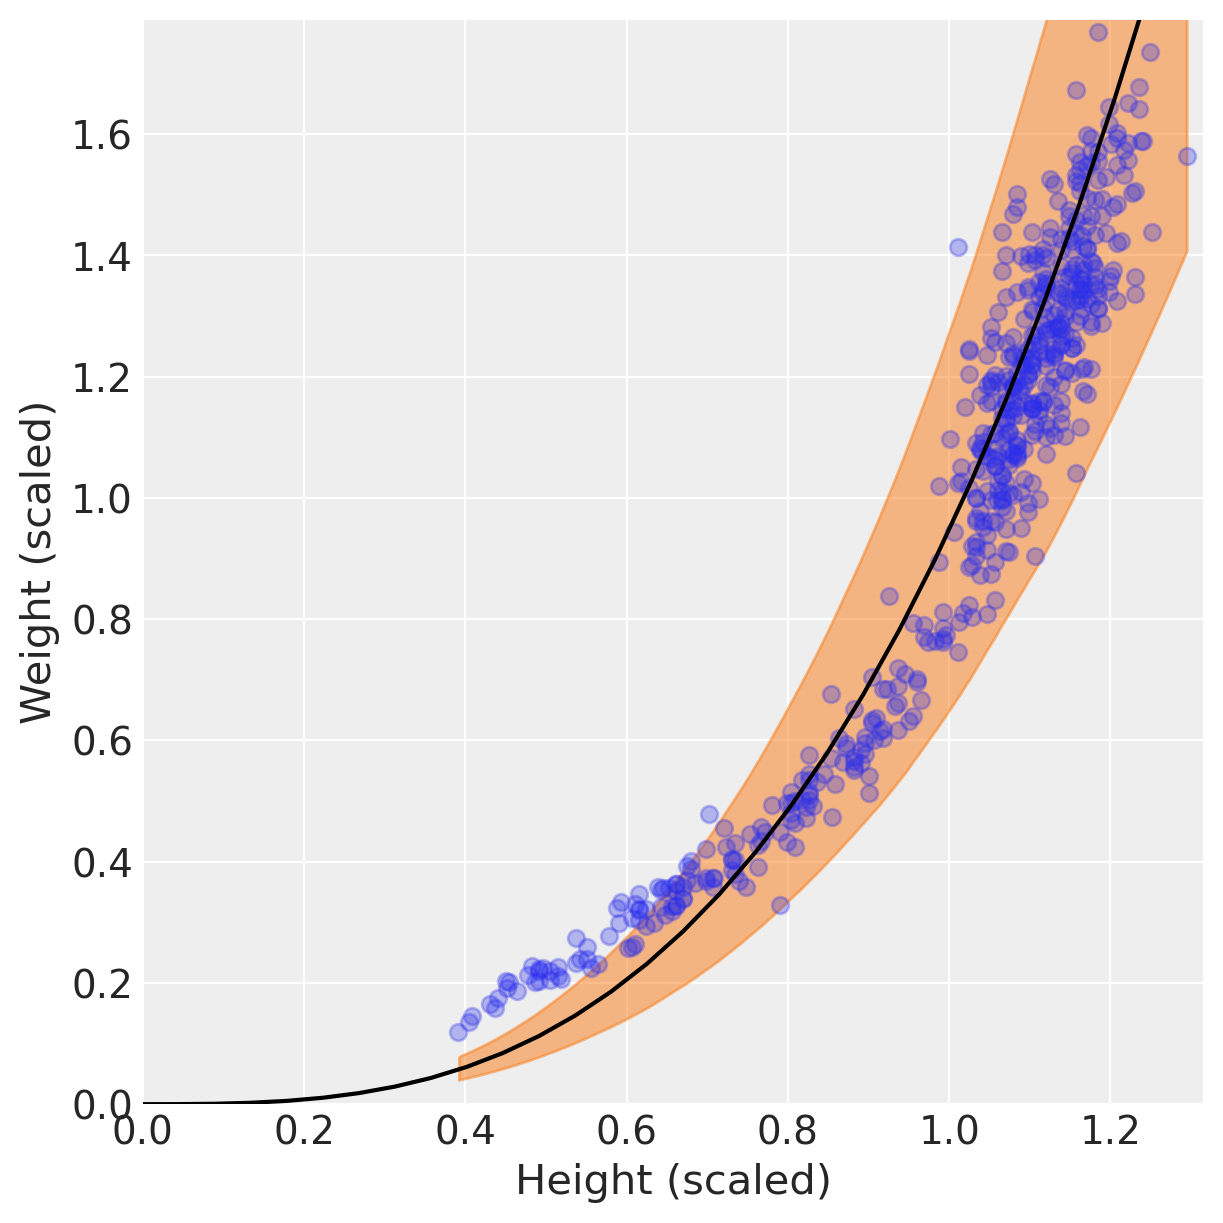

In [13]:
# Fig 16.2 (right) in the text
_, ax = plt.subplots(figsize=(6, 6))
az.plot_hdi(d.h.values, w_sim, ax=ax)
ax.scatter(d.h, d.w, c="C0", alpha=0.3)
ax.plot(h_seq, mu_mean, "k")
ax.set_xlim([0, d.h.max() + 0.02])
ax.set_ylim([0, d.w.max() + 0.02])
ax.set_xlabel("Height (scaled)")
ax.set_ylabel("Weight (scaled)");

Note there seems to be an error in Figure 16.2 of the book, as the axes limits are unit-scaled, whereas the mean of the data should appear at coordinates 1.0.

#### Code 16.4

In [14]:
df = pd.read_csv("Data/Boxes.csv", delimiter=";")
df.describe()

,y,gender,age,majority_first,culture
count,629.000000,629.000000,629.000000,629.000000,629.000000
mean,2.120827,1.505564,8.030207,0.484897,3.751987
std,0.727986,0.500367,2.497906,0.500170,1.960319
min,1.000000,1.000000,4.000000,0.000000,1.000000
25%,2.000000,1.000000,6.000000,0.000000,3.000000
50%,2.000000,2.000000,8.000000,0.000000,3.000000
75%,3.000000,2.000000,10.000000,1.000000,5.000000
max,3.000000,2.000000,14.000000,1.000000,8.000000


#### Code 16.5

In [15]:
df["y"].value_counts(normalize=True, sort=False)

y
1    0.211447
3    0.332273
2    0.456280
Name: proportion, dtype: float64

#### Code 16.6

In [16]:
N = 30  # number of children

# half are random
# sample from 1, 2, 3 at random for each
y1 = np.random.randint(low=1, high=4, size=N // 2)

y2 = np.full(shape=N // 2, fill_value=2)

y = np.random.permutation(np.hstack((y1, y2)))
np.sum(y == 2) / N

0.6333333333333333

#### Code 16.7

In [17]:
def logp(value, p, majority_first):

    phi = [None] * 5

    # Probability of data
    phi[0] = pt.switch(pt.eq(value, 2), 1, 0)
    phi[1] = pt.switch(pt.eq(value, 3), 1, 0)
    phi[2] = pt.switch(pt.eq(value, 1), 1, 0)
    phi[3] = pt.ones_like(value) * 1 / 3
    phi[4] = pt.switch(
        pt.eq(majority_first, 1), pt.switch(pt.eq(value, 2), 1, 0), pt.switch(pt.eq(value, 3), 1, 0)
    )

    # Compute log ( p_s * Pr(y_i|s) )
    phi = pt.concatenate([p[None] for p in phi], axis=0)
    phi = pt.log(phi) + pt.log(p[:, None])

    # Compute average log-probability of y_i
    return pt.sum(pm.math.logsumexp(phi, axis=0))


with pm.Model() as m16_2:
    # prior
    p = pm.Dirichlet("p", np.array([4, 4, 4, 4, 4]))

    # majority first data
    majority_first = pm.ConstantData("majority_first", df["majority_first"].values)

    # likelihood
    y = pm.DensityDist(
        "y", p, majority_first, logp=logp, ndims_params=[1, 0], observed=df["y"].values
    )

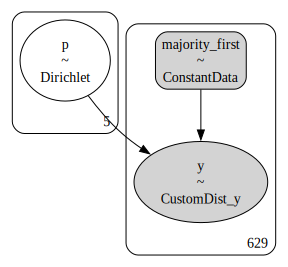

In [18]:
pm.model_to_graphviz(m16_2)

#### Code 16.8

In [19]:
with m16_2:
    m16_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.


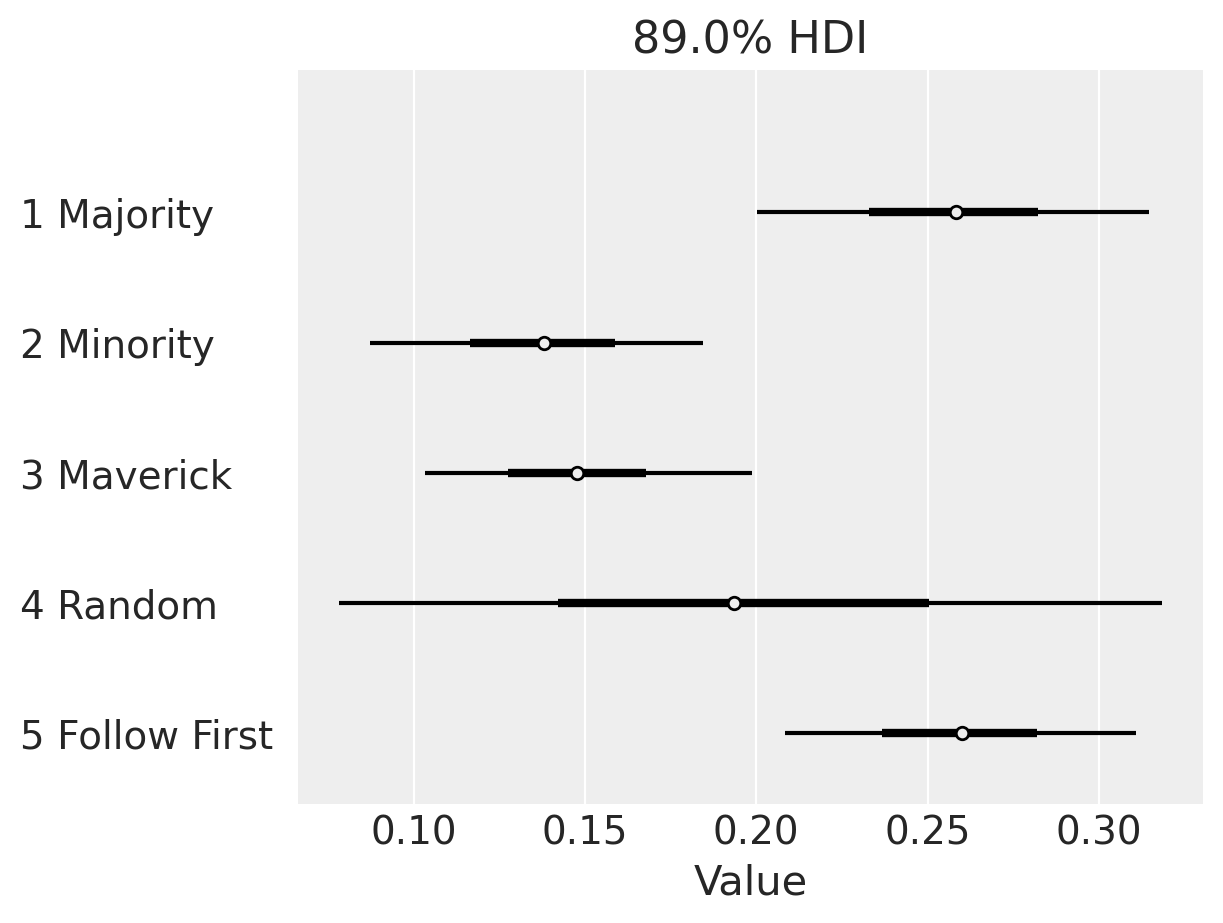

In [20]:
ax = az.plot_forest(m16_2_trace, combined=True, colors="black")

ax = ax[0]
ax.set_yticklabels(
    ["5 Follow First", "4 Random", "3 Maverick", "2 Minority", "1 Majority"], ha="left"
)
ax.get_yaxis().set_tick_params(pad=100)
ax.set_xlabel("Value");

#### Code 16.9

In [21]:
Panda_nuts = pd.read_csv("Data/Panda_nuts.csv", delimiter=";")
Panda_nuts.head()

,chimpanzee,age,sex,hammer,nuts_opened,seconds,help
0,11,3,m,G,0,61.0,N
1,11,3,m,G,0,37.0,N
2,18,4,f,wood,0,20.0,N
3,18,4,f,G,0,14.0,y
4,18,4,f,L,0,13.0,N


#### Code 16.10

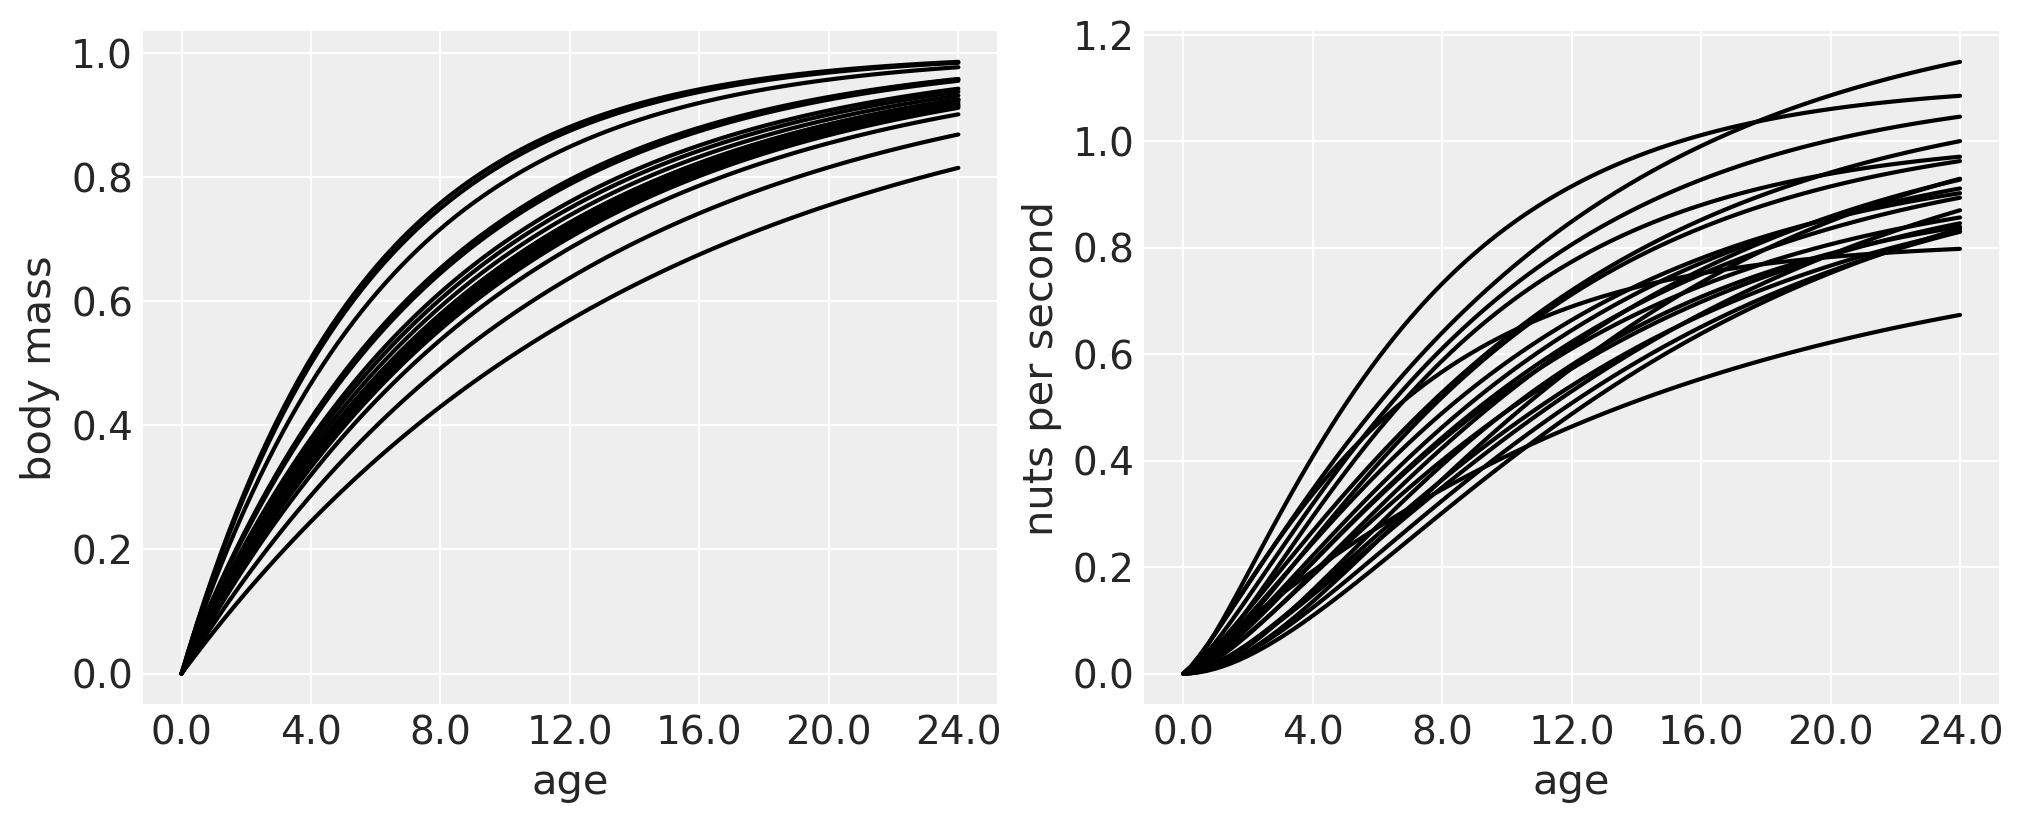

In [22]:
N = 10000
phi = np.random.lognormal(np.log(1), 0.1, N)
k = np.random.lognormal(np.log(2), 0.25, N)
theta = np.random.normal(np.log(5), 0.25, N)

# relative grow curve
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
x = np.linspace(0, 1.5, 100)
at = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
for i in range(20):
    ax[0].plot(x, 1 - np.exp(-k[i] * x), c="k")
ax[0].set_xticks(at, labels=at * np.max(Panda_nuts["age"].values))
ax[0].set_xlabel("age")
ax[0].set_ylabel("body mass")

# implied rate of nut opening curve
for i in range(20):
    ax[1].plot(x, phi[i] * (1 - np.exp(-k[i] * x)) ** theta[i], c="k")
ax[1].set_xticks(at, labels=at * np.max(Panda_nuts["age"].values))
ax[1].set_xlabel("age")
ax[1].set_ylabel("nuts per second");

#### Code 16.11

In [23]:
with pm.Model() as m16_4:

    # Data
    age = pm.Data("age", (Panda_nuts["age"] / np.max(Panda_nuts["age"])).values)
    seconds = pm.Data("seconds", Panda_nuts["seconds"].values)

    # Prios
    theta = pm.LogNormal("theta", np.log(5), 0.25)
    k = pm.LogNormal("k", np.log(2), 0.25)
    phi = pm.LogNormal("phi", np.log(1), 0.1)
    lam = pm.Deterministic("lam", seconds * phi * (1 - np.exp(-k * age)) ** theta)

    # Likelihood
    n = pm.Poisson("n", lam, observed=Panda_nuts["nuts_opened"].values)

    idata_16_4 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, k, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


The book mentions that we should check the chain diagnostics. We will do that here.

In [24]:
az.summary(idata_16_4, var_names=["theta", "k", "phi"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,9.821,2.043,6.729,13.134,0.059,0.042,1165.0,1387.0,1.00
k,5.965,0.568,5.120,6.894,0.017,0.012,1123.0,1287.0,1.01
phi,0.867,0.040,0.801,0.928,0.001,0.001,1532.0,1720.0,1.00


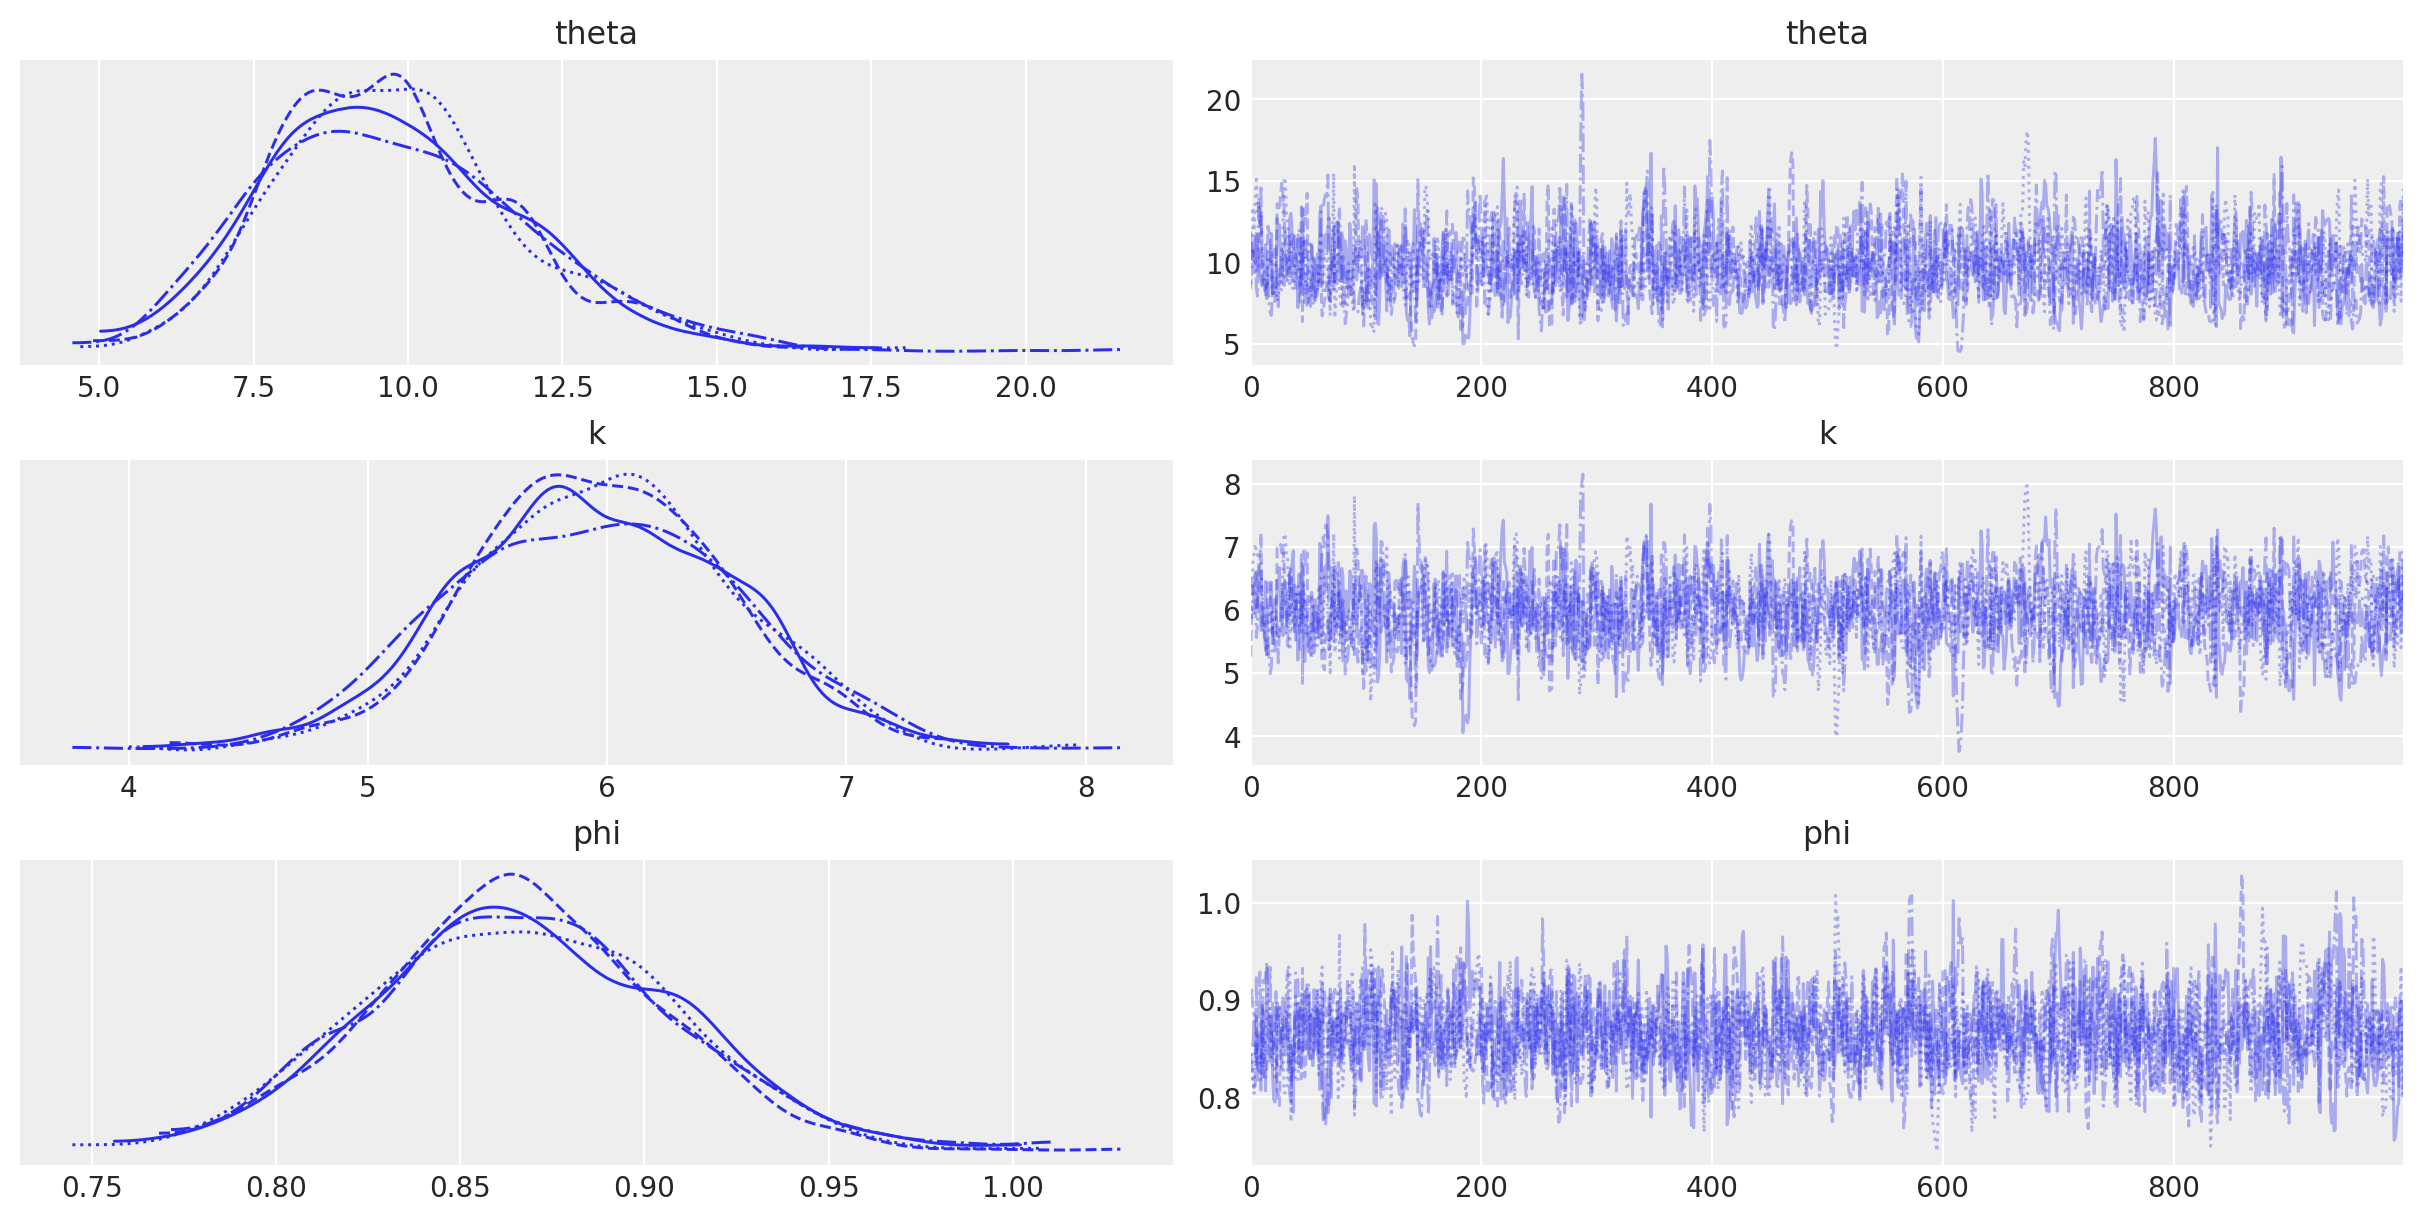

In [25]:
az.plot_trace(idata_16_4, var_names=["theta", "k", "phi"]);

#### Code 16.12

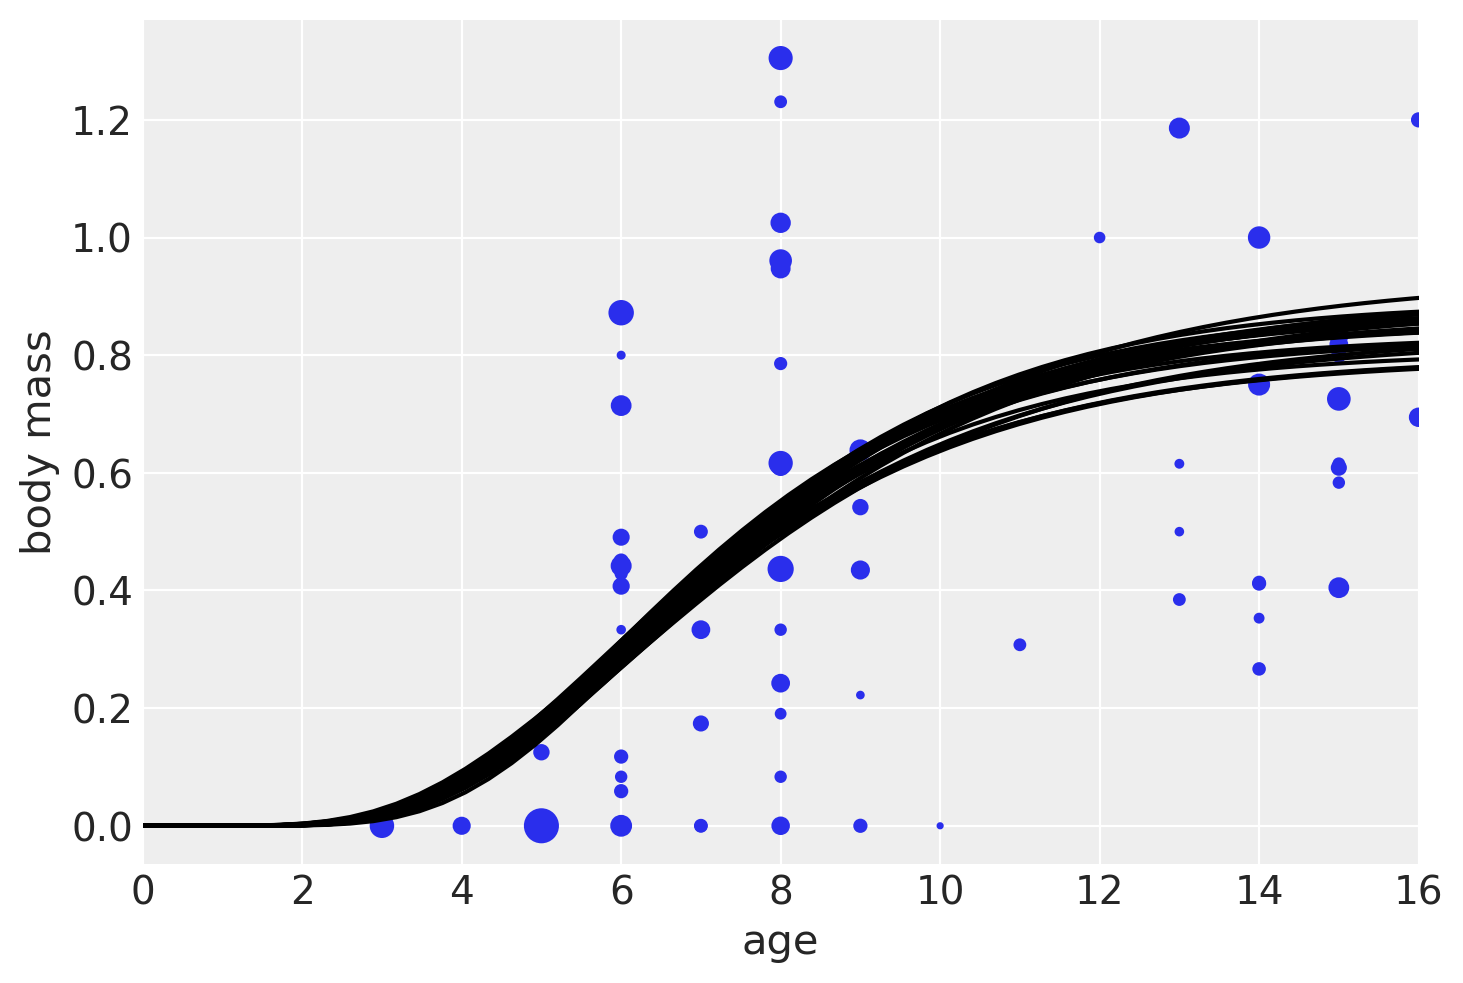

In [26]:
post = az.extract(idata_16_4, group="posterior")

x = np.linspace(0, 1.5, Panda_nuts.shape[0])
at = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
plt.xlim(0, 16)
plt.xlabel("age")
plt.ylabel("body mass")

# raw data
pts = Panda_nuts["nuts_opened"] / Panda_nuts["seconds"]
point_size = Panda_nuts["seconds"]
plt.scatter(Panda_nuts["age"], pts, s=point_size)

# 30 posterior curves
for i in range(30):
    phi = np.array(post["phi"])
    k = np.array(post["k"])
    theta = np.array(post["theta"])
    plt.plot(x * np.max(Panda_nuts["age"]), phi[i] * (1 - np.exp(-k[i] * x)) ** theta[i], c="k");

#### Code 16.13

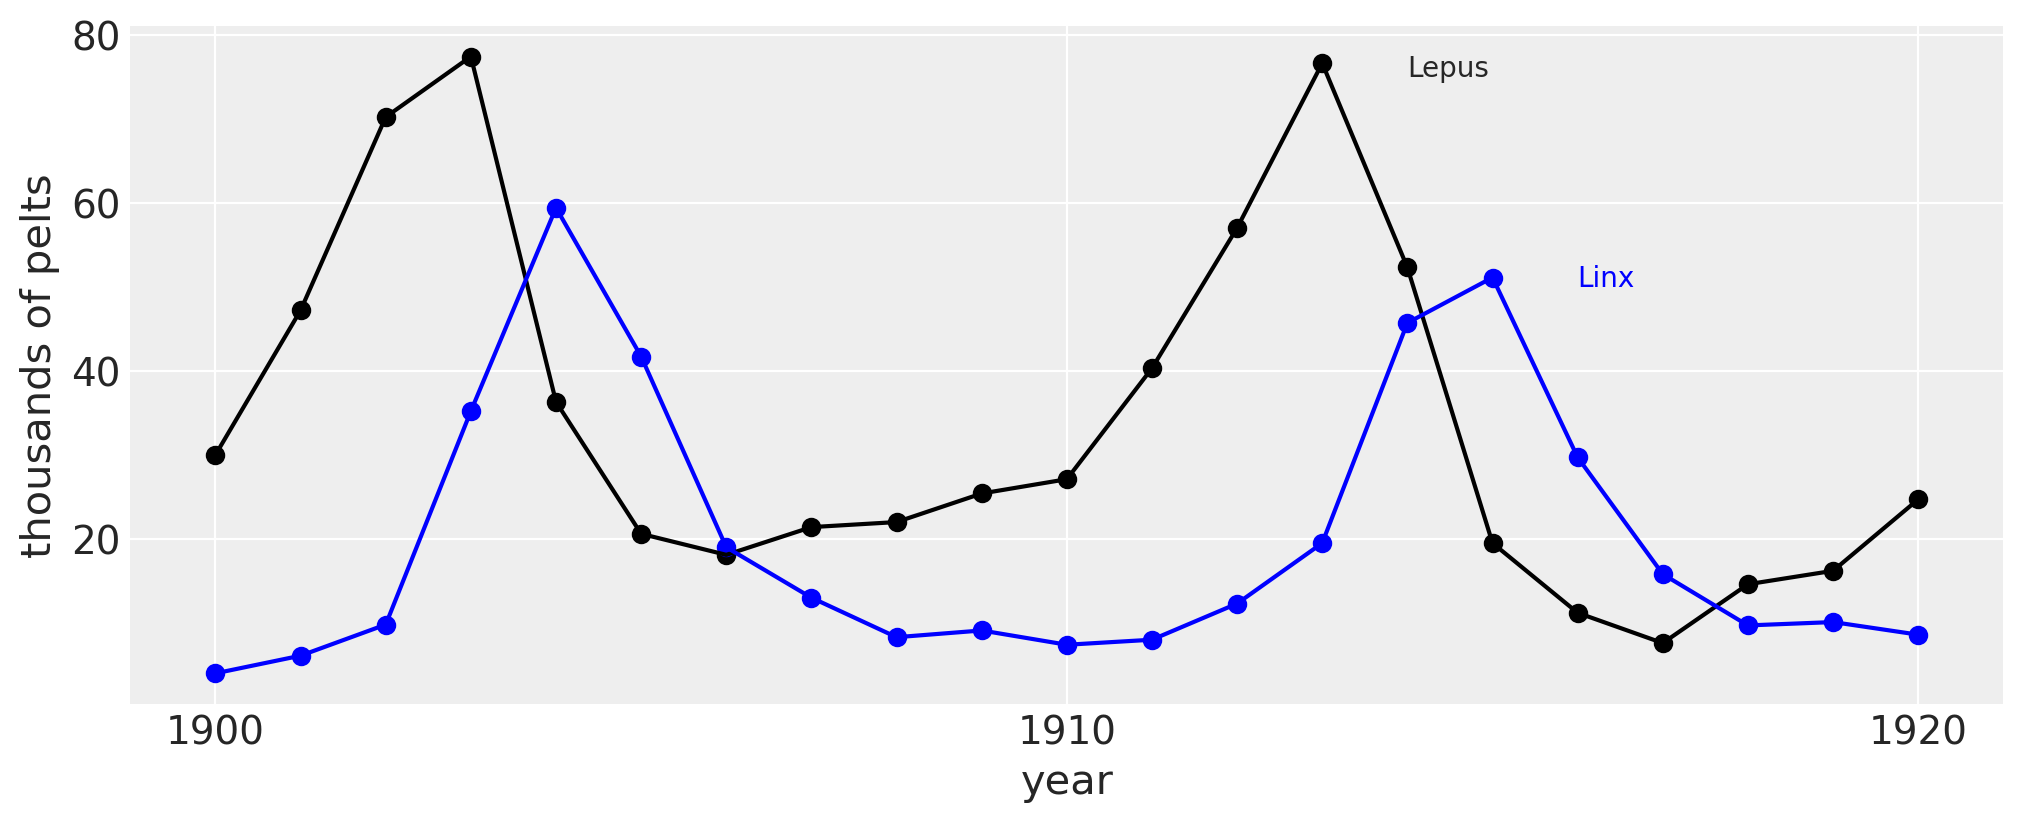

In [27]:
Lynx_Hare = pd.read_csv("Data/Lynx_Hare.csv", sep=";")
fig = plt.figure(figsize=(10, 4))
plt.plot(range(21), Lynx_Hare["Hare"], c="k")
plt.scatter(range(21), Lynx_Hare["Hare"], c="k")
plt.plot(range(21), Lynx_Hare["Lynx"], c="b")
plt.scatter(range(21), Lynx_Hare["Lynx"], c="b")
plt.xlabel("year")
plt.ylabel("thousands of pelts")


at = [0, 10, 20]
plt.xticks(at, labels=Lynx_Hare["Year"][at])

# text labels
plt.text(14, 75, "Lepus")
plt.text(16, 50, "Linx", c="b");

#### Code 16.14

In [28]:
def sim_lynx_hare(n_steps, init, theta, dt=0.002):
    L = [init[0]]
    H = [init[1]]
    for i in range(1, n_steps):
        H.append(H[-1] + dt * H[-1] * (theta[0] - theta[1] * L[-1]))
        L.append(L[-1] + dt * L[-1] * (theta[2] * H[-1] - theta[3]))

    return np.vstack([H, L]).T

#### Code 16.15

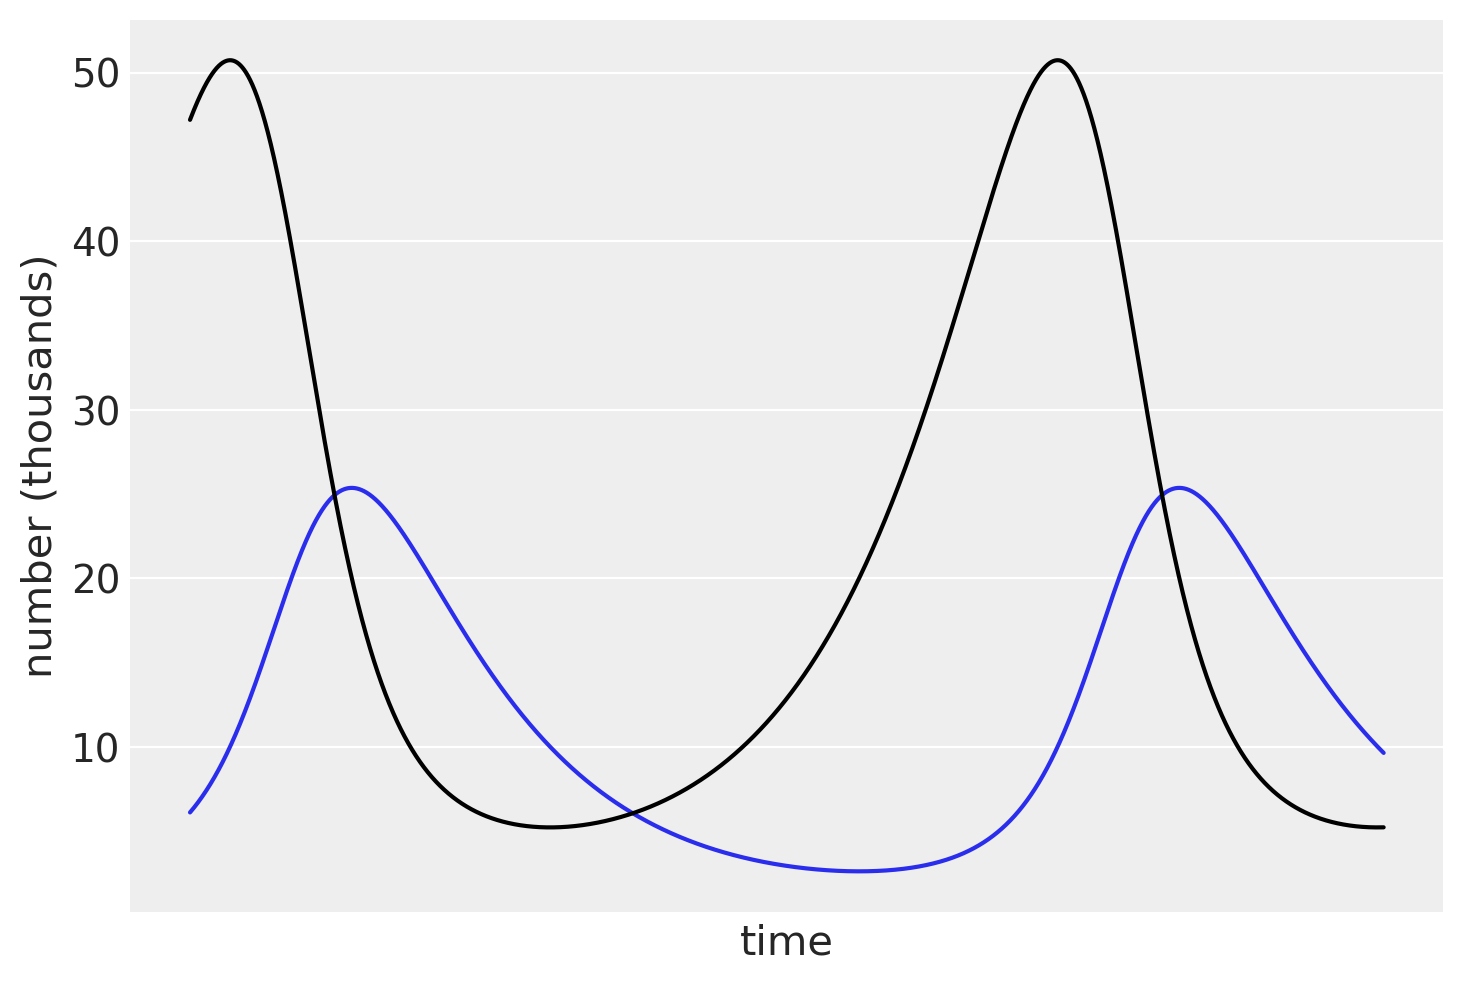

In [29]:
theta = [0.5, 0.05, 0.025, 0.5]
z = sim_lynx_hare(10000, Lynx_Hare.iloc[1, 1:3], theta)

plt.plot(z[:, 1])
plt.plot(z[:, 0], c="k")
plt.xticks([])
plt.xlabel("time")
plt.ylabel("number (thousands)");

#### Code 16.16

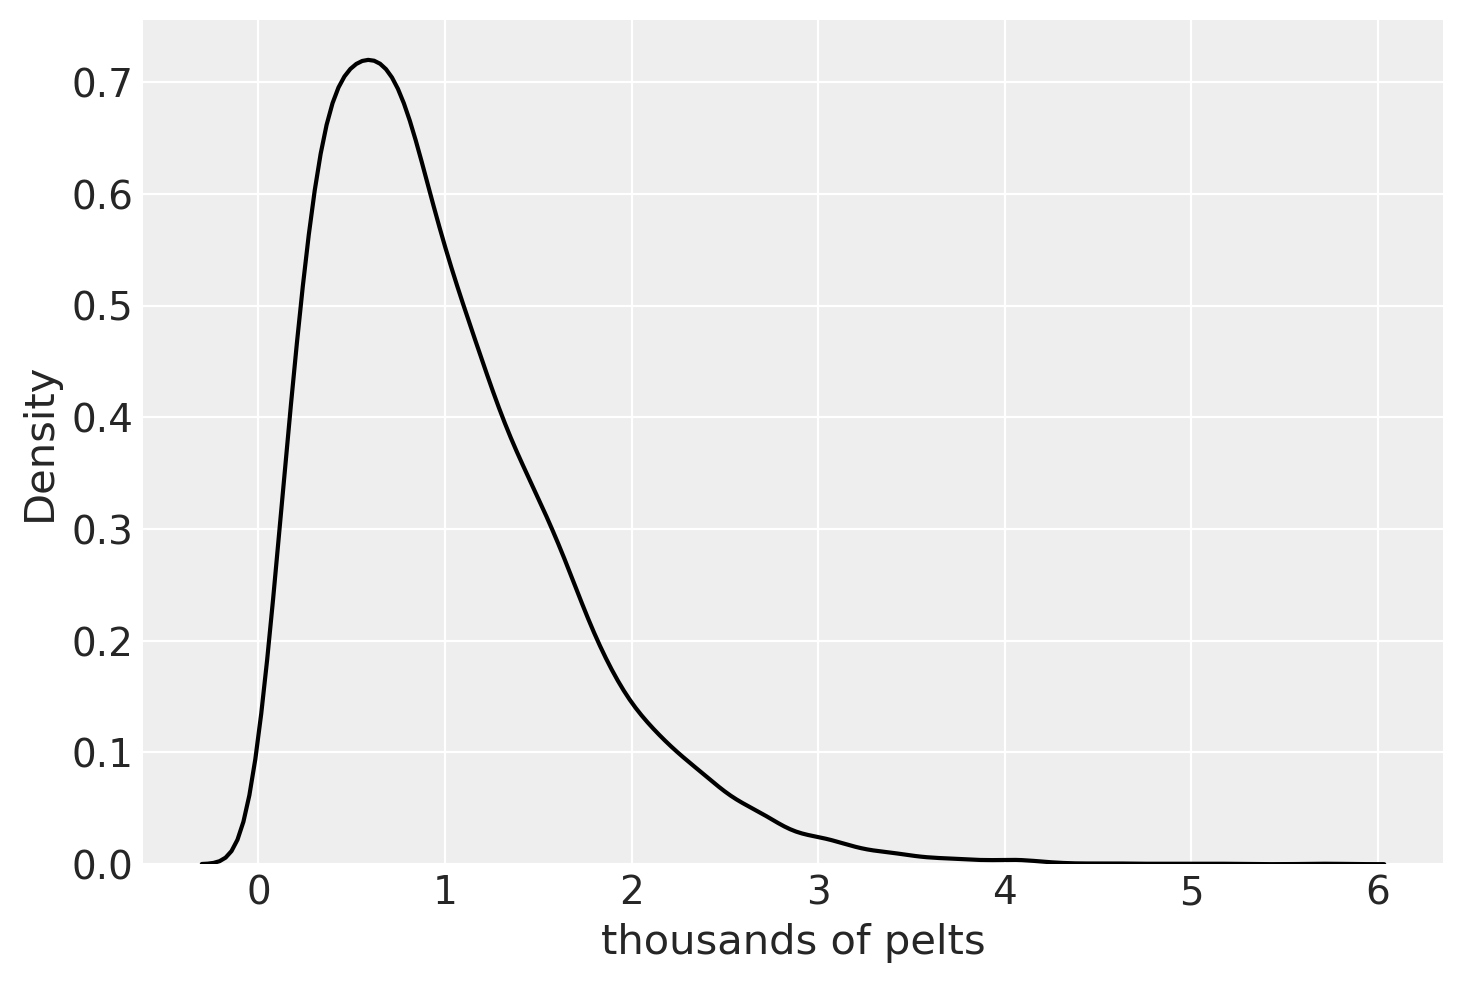

In [30]:
N = 10000
Ht = 10000
p = np.random.beta(2, 18, N)
h = np.random.binomial(N, p, Ht)
h = np.round(h / 1000, 2)

sns.kdeplot(h, c="k")
plt.xlabel("thousands of pelts");

#### Code 16.17 - 16.19

The book does not go into detail with respect to the model code. Building this model with pymc is fairly involved, but it can be done. There is an [example](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html) on the PyMC site that can be referenced for building such a model.

In [31]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Jan 12 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

arviz     : 0.17.0
pymc      : 5.10.3
seaborn   : 0.12.2
pytensor  : 2.18.4
pandas    : 2.1.4
matplotlib: 3.8.2
numpy     : 1.26.3

Watermark: 2.4.3

